In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (precision_score, recall_score,
                             precision_recall_curve,f1_score, 
                             fbeta_score, confusion_matrix)


from splits import split_users # contains split_users func

pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 100)

In [2]:
# read in pickled feature DF generated by feature_engineering_3.ipynb
X = pd.read_pickle("./pickle/X_F.pickle")

In [3]:
with open(f"models/xgboost_fit_all.pickle", "rb") as pfile:
        xgb_fit = pickle.load(pfile)

In [4]:
X_train, X_test, y_train, y_test = split_users(X, subset=False, test_size=0.2)


    X_train sample size: 6782401
    X_test sample size: 1692260


In [5]:
xgb_fit.score(X_test, y_test)

0.9098140947608524

In [6]:
preds = xgb_fit.predict(X_test)

In [7]:
f1_score(y_test, preds)

0.2723744684097107

In [131]:
with open(f"models/grid_xgb.pickle", "rb") as pfile:
        xgb_grid_fit = pickle.load(pfile)

In [133]:
grid_preds = xgb_grid_fit.predict(X_test)

ValueError: feature_names mismatch: ['user_total_prod_orders', 'in_last_cart', 'prod_prior_sales', 'prod_pct_reorders', 'prod_avg_atco', 'user_avg_ippo', 'user_avg_spacing', 'order_hour_of_day', 'days_since_prior_order_avg', 'streak_-2.0', 'streak_-3.0', 'streak_-4.0', 'streak_1.0', 'streak_2.0', 'streak_3.0', 'streak_4.0', 'streak_5.0', 'streak_nan', 'up_n5_n_buys', 'up_n5_buy_ratio'] ['user_total_prod_orders', 'in_last_cart', 'qty_reordered', 'qty_sold', 'prod_reorder_pct', 'prod_prior_sales', 'prod_pct_reorders', 'prod_avg_atco', 'user_avg_cart_size', 'days_since_prior_order', 'order_hour_of_day', 'user_avg_spacing', 'streak_nan', 'up_buy_streak', 'up_n5_n_buys', 'up_n5_buy_ratio', 'up_atco_sum', 'up_atco_avg', 'prod_total_mkt_share', 'prod_total_mkt_share_log', 'aisle_total_sales', 'prod_aisle_mkt_share', 'prod_aisle_mkt_share_log', 'streak_abs']
expected streak_3.0, streak_4.0, streak_5.0, streak_2.0, streak_-3.0, streak_1.0, user_avg_ippo, days_since_prior_order_avg, streak_-4.0, streak_-2.0 in input data
training data did not have the following fields: up_buy_streak, streak_abs, user_avg_cart_size, prod_aisle_mkt_share_log, aisle_total_sales, prod_reorder_pct, prod_total_mkt_share_log, qty_reordered, up_atco_avg, qty_sold, up_atco_sum, days_since_prior_order, prod_aisle_mkt_share, prod_total_mkt_share

# Determining the Optimal Probability Threshold

What will Instacart use this model for?

This is an important question to consider at every stage, especially when determining our probability threshold. We can adjust the threshold meter in the below confusion matrix to determine the optimal probability threshold our model uses to classify inputs. A higher threshold means the model will be less likely to classify an input as a 'reorder'. A lower threshold results in more `1` predictions. If our model were a person, the person would *need less convincing* to predict `1` with a *lower threshold*.

**So...what does that mean for our Instacart dataset?**

Instacart uses the model's predictions for two use-cases (per their [blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)):
1. "Buy it Again?" user prompts
2. "Frequently bought with..." user prompt when shopping


In both cases, the 'risk' of making false reorder predictions seems pretty low (if any). In practice, this means to prioritize **recall** (`predicted positives / all positives`) & reduce false negatives as much as possible. We'll intentionally be inflating our false positives (incorrectly predicting an item as a reorder in the user's next cart). Doing this should benefit Instacart, as highlighting these items to the user may increase conversion.

In summary, **our goal is find a low enough probability threshold in which items that the user *might* purchase are captured, while still correctly classifying products the user is very unlikely to purchase.**

Let's try and find a reasonable probability threshold using the below slider & confusion matrix.

In [128]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    
    confusion = confusion_matrix(y_test, y_predict)
    
    # get stats
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = (2 * precision * recall) / (precision + recall)
    
    plt.figure(dpi=80, figsize=(6, 6))
    
    group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
    labels = [f"{v2}\n\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    label_font = {'family': 'LiHei Pro',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 23,
        }
    
    sns.set(font_scale=1.6)
    # good cmaps: RdYlBu, coolwarm, RdBu
    sns.heatmap(confusion, annot=labels, fmt="", cmap="coolwarm", cbar=False);
    plt.xlabel('Prediction', fontdict=label_font)
    plt.ylabel('Actual', fontdict=label_font)

In [129]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(xgb_fit, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [85]:
threshold = 0.14

y_predict = (xgb_fit.predict_proba(X_test)[:, 1] >= threshold)

confusion = confusion_matrix(y_test, y_predict)

Best threshold: 0.14

So what's our new precision and F1 metrics, using this threshold?

**Precision = TruePositives / (TruePositives + FalsePositives)**

**Recall = TruePositives / (TruePositives + FalseNegatives)**

In [14]:
confusion

array([[1264308,  262597],
       [  56154,  109201]])

In [15]:
true_pos = confusion[1][1]
true_neg = confusion[0][0]

false_pos = confusion[0][1]
false_neg = confusion[1][0]

In [16]:
precision = true_pos / (true_pos + false_pos)

precision

0.29371056326284706

In [17]:
recall = true_pos / (true_pos + false_neg)

recall

0.6604033745577697

And now...our adjusted F-1 score

F-1 = (2 * Precision * Recall) / (Precision + Recall)

In [18]:
f1 = (2 * precision * recall) / (precision + recall)

f1

0.40659179042097876

In [19]:
type(xgb_fit)

xgboost.sklearn.XGBClassifier

In [20]:
def get_threshold_f1s(model, X_test, y_test, min_threshold=0.01, max_threshold=1.0):
    
    thresholds = {}
    
    for threshold in np.arange(min_threshold, max_threshold, 0.01):
        print(f"Starting threshold {round(threshold * 100, 0)}%...")
        
        # create confusion matrix
        preds = (model.predict_proba(X_test)[:, 1] >= threshold)
        confusion = confusion_matrix(y_test, preds)
        
        # extract values needed for precision/recall/f-1 calculations
        true_pos = confusion[1][1]
        false_pos = confusion[0][1]
        false_neg = confusion[1][0]
        
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f1 = (2 * precision * recall) / (precision + recall)
        thresholds[threshold] = f1
        
        print(f"End calculating {threshold*100}%. Result: {f1:.6f}")
    
    return thresholds

thresholds = get_threshold_f1s(xgb_fit, X_test, y_test, min_threshold=0.1, max_threshold=0.35)


Starting threshold 10.0%...
End calculating 10.0%. Result: 0.361029
Starting threshold 11.0%...
End calculating 11.0%. Result: 0.374797
Starting threshold 12.0%...
End calculating 12.0%. Result: 0.386346
Starting threshold 13.0%...
End calculating 13.0%. Result: 0.396790
Starting threshold 14.0%...
End calculating 13.999999999999998%. Result: 0.406592
Starting threshold 15.0%...
End calculating 14.999999999999996%. Result: 0.414715
Starting threshold 16.0%...
End calculating 15.999999999999998%. Result: 0.420941
Starting threshold 17.0%...
End calculating 17.0%. Result: 0.426017
Starting threshold 18.0%...
End calculating 17.999999999999996%. Result: 0.430297
Starting threshold 19.0%...
End calculating 18.999999999999993%. Result: 0.434061
Starting threshold 20.0%...
End calculating 19.999999999999996%. Result: 0.436415
Starting threshold 21.0%...
End calculating 20.999999999999996%. Result: 0.437359
Starting threshold 22.0%...
End calculating 21.999999999999993%. Result: 0.437900
Star

In [21]:
thresholds

{0.1: 0.361028804412178,
 0.11: 0.37479669917941094,
 0.12: 0.38634551751685275,
 0.13: 0.39678976984246483,
 0.13999999999999999: 0.40659179042097876,
 0.14999999999999997: 0.414715349876899,
 0.15999999999999998: 0.42094076083684995,
 0.16999999999999998: 0.42601715808834717,
 0.17999999999999997: 0.43029737455752565,
 0.18999999999999995: 0.43406142535278075,
 0.19999999999999996: 0.4364145921325461,
 0.20999999999999996: 0.4373594383976299,
 0.21999999999999995: 0.43790029960499305,
 0.22999999999999995: 0.4375826545014058,
 0.23999999999999994: 0.43639683505782106,
 0.24999999999999992: 0.43474531909419184,
 0.2599999999999999: 0.43301036968599177,
 0.2699999999999999: 0.43079544284363563,
 0.2799999999999999: 0.4279900795303799,
 0.2899999999999999: 0.42446211181758675,
 0.29999999999999993: 0.41988342755373265,
 0.30999999999999994: 0.4151302715831309,
 0.3199999999999999: 0.41057314691428537,
 0.32999999999999985: 0.40537027769476974,
 0.33999999999999986: 0.3992999382298438}

In [22]:
def pull_max_f1(f1_thresholds):
    """
    Parameters
    _____
    f1_thresholds(dict, required): Mapping, like {probability_threshold: f1_score}
    
    Returns:
    _____
    String containing the threshold parameter resulting in the highest F-1 score.
    """
    # pull the threshold with the highest f-1 score
    max_f1 = (0, 0)
    for thresh, f1 in thresholds.items():
        
        if f1 > max_f1[1]:
            max_f1 = thresh, f1
        continue
    
    return print(f"Best threshold: {max_f1[0]}\n Resulting F-1 score: {max_f1[1]}")
        
        
pull_max_f1(thresholds)

Best threshold: 0.21999999999999995
 Resulting F-1 score: 0.43790029960499305


## Now we have our optimal threshold (in terms of F1).

Details:
* Threshold: `0.22`
* Resulting F-1 score: `0.4379`

**Let's take a look at how our new predictions look using this probability threshold.**


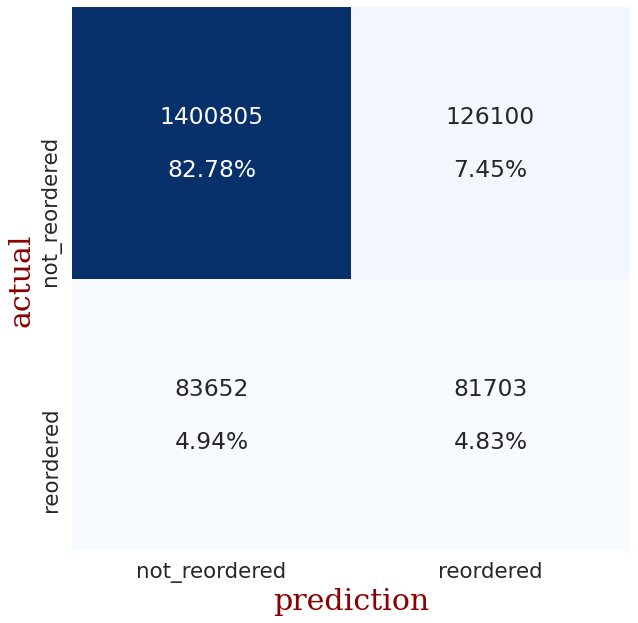

In [40]:
make_confusion_matrix(xgb_fit, threshold=0.22)

In [23]:
optimal_threshold = 0.22

In [24]:
preds = xgb_fit.predict(X_test)

In [25]:
preds_praba = xgb_fit.predict_proba(X_test)[:, 1] >= optimal_threshold

In [26]:
f1_score(y_test, preds)

0.2723744684097107

In [27]:
precision_score(y_test, preds)

0.6434573018268646

In [28]:
recall_score(y_test, preds)

0.1727495388709141

# Precision/Recall

In [29]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, preds_praba)

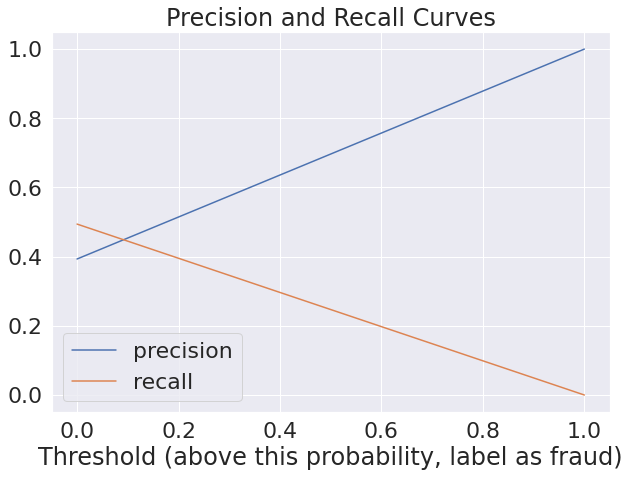

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

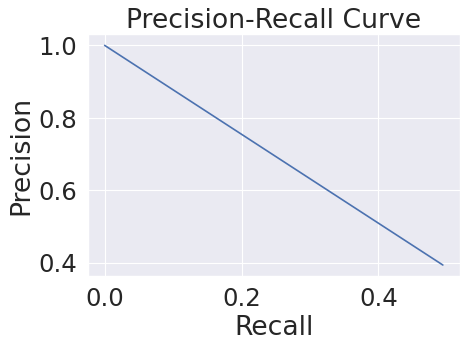

In [31]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");